<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Qubit-example" data-toc-modified-id="Qubit-example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Qubit example</a></span></li><li><span><a href="#Generating-Data" data-toc-modified-id="Generating-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generating Data</a></span></li><li><span><a href="#Creating-the-$\beta$-VAE" data-toc-modified-id="Creating-the-$\beta$-VAE-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Creating the $\beta$-VAE</a></span></li></ul></div>

# Qubit example

Here we reproduce the result of tomography qubits from the [Iten and Metger et al. paper](https://arxiv.org/abs/1807.10300).

In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os 

from Models.VAE_Keras import Dense_VariationalAutoencoder_Keras, Scinet_VariationalAutoencoder_Keras

import numpy as np
import matplotlib.pyplot as plt

# Generating Data

Data generation taken from [this github repository](https://github.com/eth-nn-physics/nn_physical_concepts)

In [16]:
from scipy.stats import unitary_group

def random_state(qubit_num):
    return unitary_group.rvs(2**qubit_num)[:, 0]


def random_subspace_states(qubit_num, k, states_num):
    """
    qubit_num: number of qubits
    k: number of orthogonal basis vectors
    states_num: number of states randomly sampled from subspace
    """

    assert(2 * 2**qubit_num > k)
    output_states = []
    subspace_basis = (unitary_group.rvs(2**qubit_num)[:, :k]).T
    for _ in range(states_num):
        c = np.random.rand(k) - 0.5
        linear_combination = 0.j
        for i in range(k):
            linear_combination += c[i] * subspace_basis[i]
        output_states.append(linear_combination / np.linalg.norm(linear_combination))
    return output_states


def projection(a, b):
    return np.abs(np.dot(np.conj(a), b))**2


def create_data(qubit_num, measurement_num1, measurement_num2, sample_num, file_name=None, incomplete_tomography=[False, False]):
    """
    ----------------------------------------------------------------------------
    Params:
    qubit_num: number of qubits
    measurement_num1: number of projective measurements to be performed on input qubit
    measurement_num2: number of projective measurements to be performed on projection axis
    sample_num: number of training examples to be generated
    file_name: file is stored in /data/file_name.pkl.gz
    incomplete_tomography: if the i-th entry is k, then the states for the projectors M_i 
                           are sampled from a k-dimensional real subspace
    """
    states_in1 = np.empty([sample_num, 2**qubit_num], dtype=np.complex_)
    states_in2 = np.empty([sample_num, 2**qubit_num], dtype=np.complex_)
    meas_res1 = np.empty([sample_num, measurement_num1], dtype=np.float_)
    meas_res2 = np.empty([sample_num, measurement_num2], dtype=np.float_)
    output = np.empty([sample_num, 1])
    if incomplete_tomography[0]:
        fixed_states_in1 = random_subspace_states(qubit_num, incomplete_tomography[0], measurement_num1)
    else:
        fixed_states_in1 = [random_state(qubit_num) for _ in range(measurement_num1)]
        
    if incomplete_tomography[1]:
        fixed_states_in2 = random_subspace_states(qubit_num, incomplete_tomography[1], measurement_num2)
        
    else:
        fixed_states_in2 = [random_state(qubit_num) for _ in range(measurement_num2)]
    for i in range(sample_num):
        states_in1[i] = random_state(qubit_num)
        states_in2[i] = random_state(qubit_num)
        meas_res1[i] = np.array([projection(s1, states_in1[i]) for s1 in fixed_states_in1])
        meas_res2[i] = np.array([projection(s2, states_in2[i]) for s2 in fixed_states_in2])
        output[i, 0] = projection(states_in1[i], states_in2[i])
    result = ([meas_res1, meas_res2, output], [states_in1, states_in2], [fixed_states_in1, fixed_states_in2])

    return result

In [17]:
#simulation parameters
qubit_n = 1
meas_num1 = 10
meas_num2 = 10
samples = 10000

validation_size_p = 5 # % of validation set

In [18]:
%timeit
data, states, params = create_data(qubit_num=qubit_n, 
                                measurement_num1=meas_num1, 
                                measurement_num2=meas_num2, 
                                sample_num=samples, 
                                )

In [19]:
states = np.array(states)
train_val_separation = int(len(data[0]) * (1 - validation_size_p / 100.))
training_data = [data[i][:train_val_separation] for i in [0, 1, 2]]
training_states = states[:train_val_separation]
validation_data = [data[i][train_val_separation:] for i in [0, 1, 2]]
validation_states = states[train_val_separation:]

# Creating the $\beta$-VAE

In [97]:
ZDIM = 4

In [98]:
import os 

# run params
SECTION = 'bvae'
RUN_ID = '0001'
DATA_NAME = '{}_qubit_{}'.format(qubit_n,ZDIM)
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build'

In [99]:
vae = Scinet_VariationalAutoencoder_Keras(
    input_dim = (10,)
    , encoder_dense_units = [1024,512,256,128]
    , decoder_dense_units = [128,256,512,1024,1]
    , z_dim = ZDIM
    , q_dim = (10,)
)

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

(128,)


In [100]:
#Compile Parameters

LEARNING_RATE = 1e-3
R_LOSS_FACTOR = 1
BETA = 1e-4

In [101]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

In [102]:
# Training Parameters

BATCH_SIZE = 256
EPOCHS = 20
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [103]:
vae.train(     
      [training_data[0],training_data[1]]
    , training_data[2]
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

Epoch 1/20
 - 5s - loss: 0.0664 - vae_r_loss: 0.0660 - vae_kl_loss: 4.4028

Epoch 00001: saving model to run/bvae/0001_1_qubit_4/weights/weights-001-0.07.h5

Epoch 00001: saving model to run/bvae/0001_1_qubit_4/weights/weights.h5
Epoch 2/20
 - 3s - loss: 0.0351 - vae_r_loss: 0.0341 - vae_kl_loss: 9.4113

Epoch 00002: saving model to run/bvae/0001_1_qubit_4/weights/weights-002-0.04.h5

Epoch 00002: saving model to run/bvae/0001_1_qubit_4/weights/weights.h5
Epoch 3/20
 - 3s - loss: 0.0319 - vae_r_loss: 0.0311 - vae_kl_loss: 8.6664

Epoch 00003: saving model to run/bvae/0001_1_qubit_4/weights/weights-003-0.03.h5

Epoch 00003: saving model to run/bvae/0001_1_qubit_4/weights/weights.h5
Epoch 4/20
 - 3s - loss: 0.0279 - vae_r_loss: 0.0270 - vae_kl_loss: 9.4412

Epoch 00004: saving model to run/bvae/0001_1_qubit_4/weights/weights-004-0.03.h5

Epoch 00004: saving model to run/bvae/0001_1_qubit_4/weights/weights.h5
Epoch 5/20
 - 3s - loss: 0.0086 - vae_r_loss: 0.0076 - vae_kl_loss: 10.2185

Epo

In [79]:
#ZDIM = 1
np.sqrt(vae.model.evaluate([validation_data[0],validation_data[1]], validation_data[2])[0])

500/500 [==============================] - 0s 184us/step


0.21650654579105613

In [88]:
#ZDIM = 2
np.sqrt(vae.model.evaluate([validation_data[0],validation_data[1]], validation_data[2])[0])

500/500 [==============================] - 0s 982us/step


0.055012486343307875

In [96]:
#ZDIM = 3
np.sqrt(vae.model.evaluate([validation_data[0],validation_data[1]], validation_data[2])[0])

500/500 [==============================] - 1s 1ms/step


0.03888569131401101

In [104]:
#ZDIM = 4
np.sqrt(vae.model.evaluate([validation_data[0],validation_data[1]], validation_data[2])[0])

500/500 [==============================] - 1s 1ms/step


0.03669935256868645

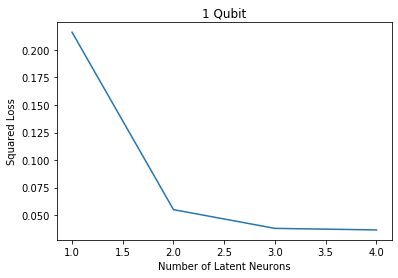

In [106]:
plt.title('1 Qubit');
plt.xlabel('Number of Latent Neurons');
plt.ylabel('Squared Loss');
plt.plot([1,2,3,4],[0.216,0.055,0.038,0.0366]);